## **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
import json


In [2]:
#Load dataset
df = pd.read_excel('data.xlsx')

df.head()


,Source,Date,Text,Category,Polarity
0,BBC Bangla,2018-06-03 00:00:00,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,other,positive
1,BBC Bangla,2018-06-04 00:00:00,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,team,positive
2,BBC Bangla,15/6/2017,বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?,team,positive
3,BBC Bangla,15/6/2020,সৌম্যকে বাদ দেওয়া হোক,batting,negative
4,BBC Bangla,27/1/2018,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",team,positive


In [3]:
#Show total columns
df.columns

Index(['Source', 'Date', 'Text', 'Category', 'Polarity'], dtype='object')

In [4]:
#Drop the unnecessary colums
df = df.drop(['Source', 'Date','Category'], axis=1)

In [5]:
df.head()


,Text,Polarity
0,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,positive
1,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,positive
2,বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?,positive
3,সৌম্যকে বাদ দেওয়া হোক,negative
4,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",positive


In [6]:
df.describe()

,Text,Polarity
count,2979,2979
unique,2720,3
top,"এই পিচে বাংলাদেশকে ৪র্থ ইনিংসে ব্যাট করতে হবে,...",negative
freq,4,2152


In [7]:
#show total numbers of pos,neg and neutral comments
print("Total Reviews:",len(df),
      "\nTotal Positive Reviews:",len(df[df.Polarity =='positive']),
      "\nTotal Negative Reviews:",len(df[df.Polarity=='negative']),
      "\nTotal Neutral Reviews:",len(df[df.Polarity =='neutral']))

Total Reviews: 2979 
Total Positive Reviews: 566 
Total Negative Reviews: 2152 
Total Neutral Reviews: 261


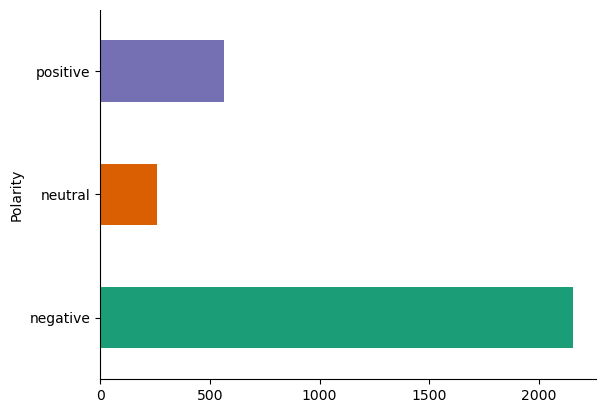

In [8]:
#visualize the data
df.groupby('Polarity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
from plotly import graph_objs as go
temp = df.groupby('Polarity').count()['Text'].reset_index().sort_values(by='Text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Polarity,Text
0,negative,2152
2,positive,566
1,neutral,261


In [10]:
df.sample(n=5, random_state=0)[['Text', 'Polarity']]


,Text,Polarity
2671,মাসরাফি আর ভারতীয় লিজেন্ড জহির খাঁন এর উইকেট ই...,positive
538,অবহেলিত মমিনুল জন্য আজ এই টেষ্ট ড্র করতে পারলাম,positive
1628,বাংলাদেশের আবাল ক্রীড়া সাংবাদিক দের মাঠে নামায়...,negative
1412,এখন টেস্ট ও একি দশা। বাকি রইলো টি২০!,negative
1725,"আমাদের শান্তনা দুজন বোলার ৪ উইকেট পাইছে,এটা নি...",negative


In [11]:
#showing some random comments and their sentiments
sample_data = [10,100,250,650]
for i in sample_data:
      print(df.Text[i],'\n','Sentiment:-- ',df.Polarity[i],'\n')

,আমার বাংলাদেশ জিদবে #$ @ ইনশা আল্লাহ।। 
 Sentiment:--  positive 

ধন্যবাদ রাজ্জাককে সুযোগ দেওয়ার জন্য। 
 Sentiment:--  positive 

 আসেন এখন আমরা বাংলাদেশ টিমরে গাইলাই 
 Sentiment:--  negative 

 আরো আগে রাজ্জাকের প্রত্যাবর্তন করা দরকার ছিল 
 Sentiment:--  positive 



## **Data Preprocessing**

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raquib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#Data Cleaning
def process_text(Text):
    Text = re.sub('[^\u0980-\u09FF]',' ',str(Text)) #removing unnecessary punctuation
    Text = re.sub('[?.`*^()!°¢܌Ͱ̰ߒנ~×Ҡߘ:ҰߑÍ|।;!,&%\'@#$><A-Za-z0+-9=./''""_০-৯]', '', str(Text))
    Text = re.sub(r'(\W)(?=\1)', '', str(Text))
    Text = re.sub(r'https?:\/\/.*[\r\n]*', '', str(Text), flags=re.MULTILINE)
    Text = re.sub(r'\<a href', ' ', str(Text))
    Text = re.sub(r'&amp;', '', str(Text))
    Text = re.sub(r'<br />', ' ', str(Text))
    Text = re.sub(r'\'', ' ', str(Text))
    Text = re.sub(r'ߑͰߑ̰ߒנ', '', str(Text))
    Text = re.sub(r'ߎɰߎɰߎɍ', '', str(Text))
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('bengali')) + r')\b\s*')
    Text = pattern.sub('', Text)
    return Text

In [14]:
# Apply the function into the dataframe
df['cleaned'] = df['Text'].apply(process_text)

# print some cleaned reviews from the dataset
sample_data = [10,100,250]
for i in sample_data:
     print('Original:\n',df.Text[i],'\nCleaned:\n',
           df.cleaned[i],'\n','Textiment:-- ',df.Polarity[i],'\n')

Original:
 ,আমার বাংলাদেশ জিদবে #$ @ ইনশা আল্লাহ।। 
Cleaned:
  বাংলাদেশ জিদবে ইনশা আল্লাহ  
 Textiment:--  positive 

Original:
 ধন্যবাদ রাজ্জাককে সুযোগ দেওয়ার জন্য। 
Cleaned:
 ধন্যবাদ াজ্জাককে সুযোগ ্য  
 Textiment:--  positive 

Original:
  আসেন এখন আমরা বাংলাদেশ টিমরে গাইলাই 
Cleaned:
  আসেন আমরা বাংলাদেশ মরে গাইলা 
 Textiment:--  negative 



Removing Low-length data


In [15]:
# Length of each Reveiws
df['length'] = df['cleaned'].apply(lambda x:len(x.split()))
# Remove the reviews with least words
lnt=len(df)
df = df.loc[df.length>3]
df = df.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Reviews".format(lnt-len(df)),
      "\nTotal Reviews:",len(df))

After Cleaning: 
Removed 357 Small Reviews 
Total Reviews: 2622


In [16]:
Positive_sent = df[df['Polarity']=='positive']
Negative_sent = df[df['Polarity']=='negative']
Neutral_sent = df[df['Polarity']=='neutral']

Taking only positive and Negative data

In [17]:
Positive = df[df.Polarity == 'positive']
Negative = df[df.Polarity == 'negative']
df = pd.concat([Positive, Negative], ignore_index=True)
df.Polarity.value_counts()

Polarity
negative    1943
positive     462
Name: count, dtype: int64

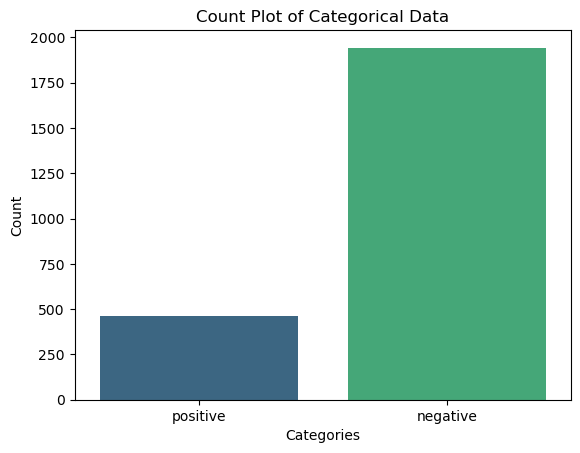

In [18]:
# visualizing positive and negative data
sns.countplot(x='Polarity', data=df, palette='viridis')
plt.title('Count Plot of Categorical Data')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

Imbalance data

## Handling Imbalancedataset

In [19]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Polarity'])

In [20]:
X=df['cleaned'].values

In [21]:
tfidf = TfidfVectorizer(ngram_range=(1,2),use_idf=True,tokenizer=lambda x: x.split())
X = tfidf.fit_transform(X)

c:\Users\raquib\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [22]:
#Handling Imbalance dataset using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

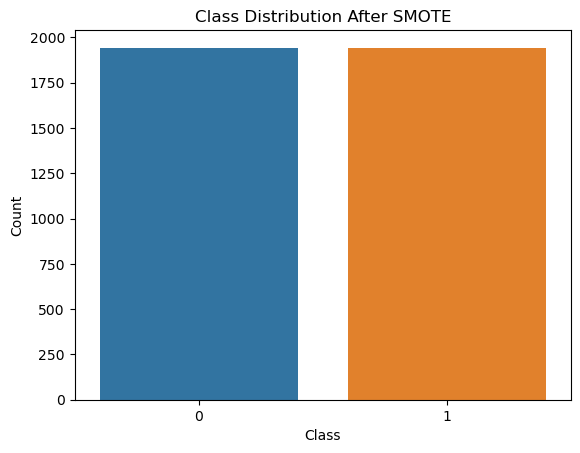

In [23]:
sns.countplot(x=y_sm)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Lable Encoding and Dataset Splitting

In [24]:
#Label Encoding Function


def label_encoding(sentiment,bool):
    """
    This function will return the encoded labels in array format.

    Args:
        sentiment: series of class names(str)
        bool: boolean (True or False)

    Returns:
        labels: numpy array
    """
    le = LabelEncoder()
    le.fit(sentiment)
    encoded_labels = le.transform(sentiment)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(sentiment[i],' ', encoded_labels[i],'\n')

    return labels



In [25]:
# Dataset Splitting Function
def dataset_split(feature_space,sentiment):
    """
    This function will return the splitted (80%-20%) feature vector .

    Args:
        feature_space: calcuated feature vector (sparse matrix)
        sentiment: encoded lables (array)

    Returns:
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array)
        y_test : testing encoded labels (array)
    """
    from imblearn.over_sampling import SMOTE

    X_train,X_test,y_train,y_test = train_test_split(feature_space,sentiment,train_size = 0.8,
                                                  test_size = 0.2,random_state=15, stratify=sentiment)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])

    return X_train,X_test,y_train,y_test

## Model Building Using Machine Learning Feature Extraction Using TF-IDF

In [26]:
# Unigram Tf-idf value calculation
def calc_gram_tfidf(reviews,gram):
    """
    This function will return the tf-idf value of the respective gram features .

    Args:
        reviews: a list of cleaned reviews

    Returns:
        tfidf: a instance of TfidfVectorizer
        X : Unigram Feature Vector (sparse matrix)
    """
    tfidf = TfidfVectorizer(ngram_range=gram,use_idf=True,tokenizer=lambda x: x.split())
    X = tfidf.fit_transform(reviews)

    return tfidf,X

In [27]:
# Importing all the ML classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve


In [28]:
#  Classifiers Defination
def ml_models_defination():
    """
    This function consists the models defination for All gram Features

    Retuns:
        ml_models: list of models
        model_names: list of model_names

    """

    lr_model = LogisticRegression(random_state = 123)
    dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    rf_model = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
    mnb_model = MultinomialNB(alpha=0.15)
    knn_model = KNeighborsClassifier(n_neighbors=3, metric = 'minkowski')
    lsvm_model = SVC(kernel = 'linear',C = 0.2, probability=True, random_state = 0)
    ksvm_model = SVC(C= 1000,kernel = 'rbf',probability=True, gamma = 0.00015, random_state = 0)
    sgd_model = SGDClassifier(loss ='log_loss',penalty='l2', max_iter=100)
    abc = AdaBoostClassifier(n_estimators=50, random_state=2)
    bc = BaggingClassifier(n_estimators=50, random_state=2)
    etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
    gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
    xgb = XGBClassifier(n_estimators=50,random_state=2)
    model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','Linear SVM','Kernel SVM','SGD','XGB','GBDT','ETC','BC','ABC']
    #model_names = ['Logistic Regression']
    # Create list of models
    ml_models = [lr_model,dt_model,rf_model,mnb_model,knn_model,lsvm_model,ksvm_model,sgd_model,xgb,gbdt,etc,bc,abc]
    #ml_models = [lr_model]
    return ml_models,model_names






In [29]:
# Model Evaluation Function
def model_performace(model,X_train,X_test,y_train,y_test):
    """
    This function will return the performance parameter values of each ML models.
    Performance parameters are Accuracy, F1-Score, Precision, Recall.

    Args:
        model: a ML model instance
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array)
        y_test : testing encoded labels (array)

    Returns:
        my_dict: a dictionary of all the parameters for each models
    """
    my_dict = {}
    model.fit(X_train,y_train)
    # Prediction
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100
    my_dict['Precision'] = round(precision_score(y_test, pred_y),4)*100
    my_dict['Recall'] = round(recall_score(y_test, pred_y),4)*100
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y),4)*100

    return my_dict

In [30]:
# Model Performane into Dataframe
def performance_table(performance_dict):
    """
    This function will create a dataframe of all the performance parameters.

    Args:
        performance_dict: a dictionary of all the parameters for each models

    Returns:
        performance_df: a dataframe
    """

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    # Create a dataframe
    model_names = ['LR','DT','RF','MNB','KNN','Linear SVM','RBF SVM','SGD','XGB','GBDT','ETC','BC','ABC']
    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list,
                                   'Model Name':model_names })
    return performance_df

## Model Training

In [31]:
## save the performance of the model for each gram feature
gram_names = ['Unigram','Bigram','Trigram']
ngrams = [(1,1),(2,2),(3,3)]
for i,gram in enumerate(ngrams):
    tfidf,X = calc_gram_tfidf(df.cleaned,gram)
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(sampling_strategy='minority')
    X_sm, y_sm = smote.fit_resample(X, y)
    X_train,X_test,y_train,y_test = dataset_split(X_sm,y_sm)
    ml_models,model_names = ml_models_defination()
    # call model accuracy function and save the metrices into a dictionary
    accuracy = {f'{model_names[j]}':model_performace(model,X_train,X_test,y_train,y_test) for j,model in enumerate(ml_models)}
    #Save the performance parameter into json file
    with open(f'ml_performance_{gram_names[i]}.json', 'w') as f:
           json.dump(accuracy, f)

c:\Users\raquib\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature Size :======> 6375

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 3886 
	Training		 3108 
	Test			 778


c:\Users\raquib\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\raquib\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature Size :======> 14215

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 3886 
	Training		 3108 
	Test			 778


c:\Users\raquib\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\raquib\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature Size :======> 13719

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 3886 
	Training		 3108 
	Test			 778


c:\Users\raquib\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


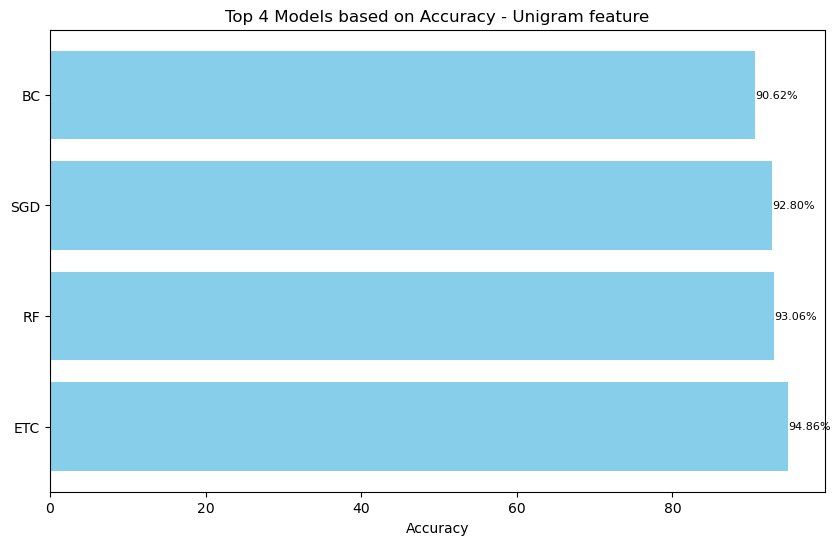

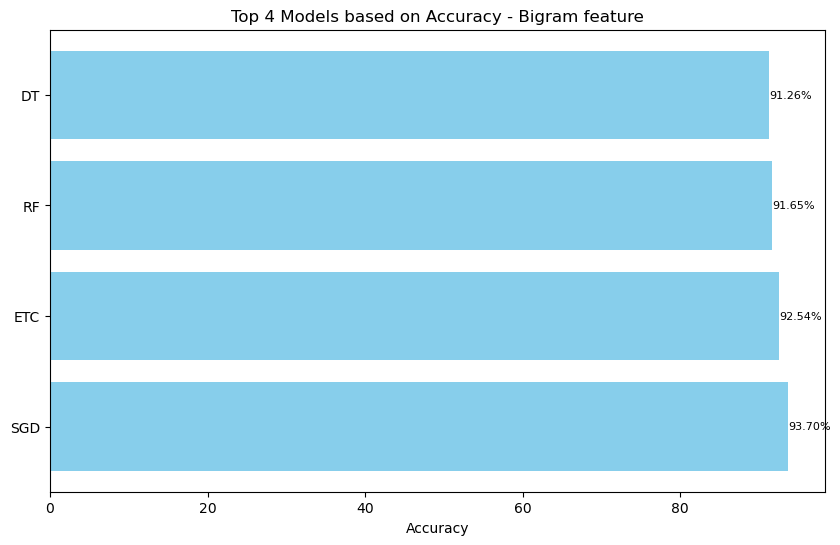

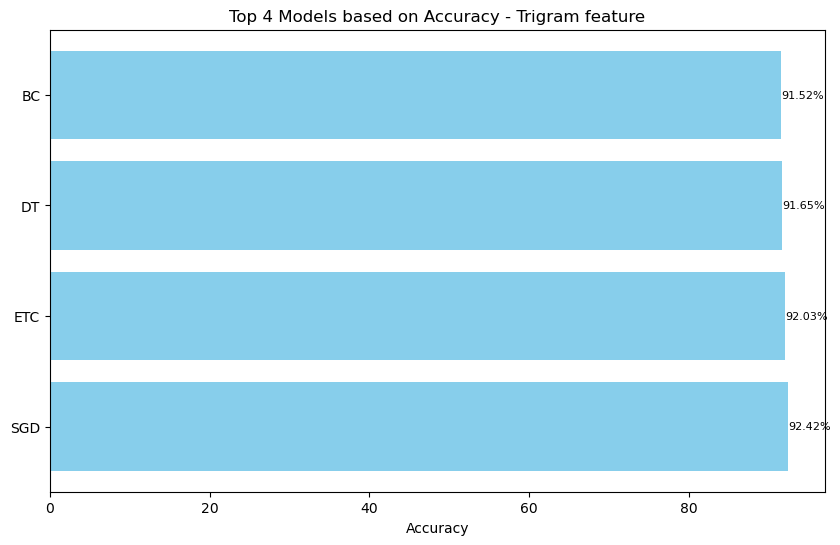

In [32]:
import json
import pandas as pd
import matplotlib.pyplot as plt

gram_names = ['Unigram', 'Bigram', 'Trigram']

for gram in gram_names:
    accuracy = json.load(open(f'ml_performance_{gram}.json'))
    table = performance_table(accuracy)

    # Sort the table based on accuracy in descending order
    table_sorted = table.sort_values(by='Accuracy', ascending=False).head(4)

    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.barh(table_sorted['Model Name'], table_sorted['Accuracy'], color='skyblue')
    plt.xlabel('Accuracy')
    plt.title(f'Top 4 Models based on Accuracy - {gram} feature')

    # Display accuracy values above the bars
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width():.2f}%',
                 va='center', ha='left', fontsize=8, color='black')

    plt.show()


In [33]:
# Load all the json files
gram_names = ['Unigram','Bigram','Trigram']

for gram in gram_names:
  accuracy = json.load(open(f'ml_performance_{gram}.json'))
  table = performance_table(accuracy)
  print(f"\n========== Performace Table for {gram} feature:========\n",table)
  print(f"\n========In case of {gram} feature:========\n")
  print(f"Highest Accuracy achieved by {table['Model Name'][table.Accuracy.idxmax(axis = 0)]} at = {max(table.Accuracy)}")
  print(f"Highest F1-Score achieved by {table['Model Name'][table['F1 Score'].idxmax(axis = 0)]} at = {max(table['F1 Score'] )}")
  print(f"Highest Precision Score achieved by {table['Model Name'][table['Precision'].idxmax(axis = 0)]} at = {max(table['Precision'] )}")
  print(f"Highest Recall Score achieved by {table['Model Name'][table['Recall'].idxmax(axis = 0)]} at = {max(table['Recall'] )}")


========== Performace Table for Unigram feature:========
     Accuracy  Precision  Recall  F1 Score  Model Name
0      89.85      88.94   91.00     89.96          LR
1      88.43      88.83   87.92     88.37          DT
2      93.06      94.67   91.26     92.93          RF
3      88.69      82.51   98.20     89.67         MNB
4      55.01      52.65   99.74     68.92         KNN
5      87.02      88.92   84.58     86.69  Linear SVM
6      89.46      89.06   89.97     89.51     RBF SVM
7      92.80      90.12   96.14     93.03         SGD
8      87.79      92.00   82.78     87.14         XGB
9      80.98      88.75   70.95     78.86        GBDT
10     94.86      94.40   95.37     94.88         ETC
11     90.62      90.51   90.75     90.63          BC
12     80.46      84.75   74.29     79.18         ABC

========In case of Unigram feature:========

Highest Accuracy achieved by ETC at = 94.86
Highest F1-Score achieved by ETC at = 94.88
Highest Precision Score achieved by RF at = 94.67
H

In [34]:
from tabulate import tabulate

gram_names = ['Unigram', 'Bigram', 'Trigram']

for gram in gram_names:
    accuracy = json.load(open(f'ml_performance_{gram}.json'))
    table = performance_table(accuracy)

    # Display performance table
    print(f"\n========== Performance Table for {gram} feature:========\n")
    headers = ["Model Name", "Accuracy", "Precision", "Recall", "F1 Score"]
    data = table[headers].values
    print(tabulate(data, headers=headers, tablefmt="grid"))

    # Display additional information
    print(f"\n======== In case of {gram} feature:========\n")
    highest_accuracy_model = table.loc[table['Accuracy'].idxmax(axis=0)]['Model Name']
    highest_f1_model = table.loc[table['F1 Score'].idxmax(axis=0)]['Model Name']
    highest_precision_model = table.loc[table['Precision'].idxmax(axis=0)]['Model Name']
    highest_recall_model = table.loc[table['Recall'].idxmax(axis=0)]['Model Name']

    print(f"Highest Accuracy achieved by {highest_accuracy_model} at = {round(max(table['Accuracy']), 2)}")
    print(f"Highest F1-Score achieved by {highest_f1_model} at = {round(max(table['F1 Score']), 2)}")
    print(f"Highest Precision Score achieved by {highest_precision_model} at = {round(max(table['Precision']), 2)}")
    print(f"Highest Recall Score achieved by {highest_recall_model} at = {round(max(table['Recall']), 2)}")



========== Performance Table for Unigram feature:========

+--------------+------------+-------------+----------+------------+
| Model Name   |   Accuracy |   Precision |   Recall |   F1 Score |
+==============+============+=============+==========+============+
| LR           |      89.85 |       88.94 |    91    |      89.96 |
+--------------+------------+-------------+----------+------------+
| DT           |      88.43 |       88.83 |    87.92 |      88.37 |
+--------------+------------+-------------+----------+------------+
| RF           |      93.06 |       94.67 |    91.26 |      92.93 |
+--------------+------------+-------------+----------+------------+
| MNB          |      88.69 |       82.51 |    98.2  |      89.67 |
+--------------+------------+-------------+----------+------------+
| KNN          |      55.01 |       52.65 |    99.74 |      68.92 |
+--------------+------------+-------------+----------+------------+
| Linear SVM   |      87.02 |       88.92 |    84.58 |  

## Showing one classifer's classification report and confusion matrix

In [35]:
X=df['cleaned'].values
tfidf = TfidfVectorizer(ngram_range=(1,1),use_idf=True,tokenizer=lambda x: x.split())
X = tfidf.fit_transform(X)

c:\Users\raquib\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [36]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [38]:
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
etc.fit(X_train,y_train)
    # Prediction
pred_y = etc.predict(X_test)
Accuracy = round(accuracy_score(y_test, pred_y),4)*100
print(Accuracy)

94.86


In [39]:
report = classification_report(y_test, pred_y)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       389
           1       0.94      0.96      0.95       389

    accuracy                           0.95       778
   macro avg       0.95      0.95      0.95       778
weighted avg       0.95      0.95      0.95       778



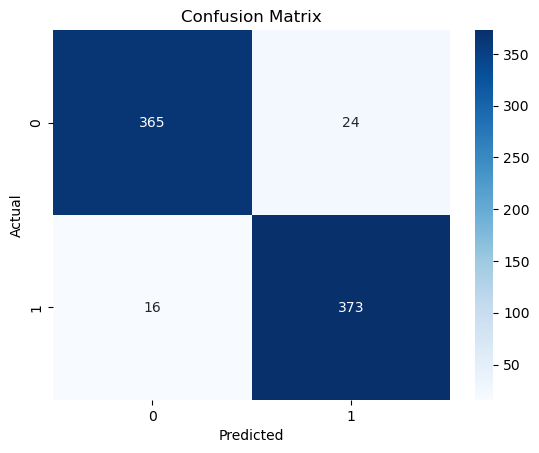

In [40]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, pred_y)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Performing grid search for searching best parameters for one model

In [41]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
rf_model.fit(X_train,y_train)
    # Prediction
pred_y = etc.predict(X_test)
Accuracy = round(accuracy_score(y_test, pred_y),4)*100
print(Accuracy)

94.86


The accuracy is 94.6%

In [42]:
report = classification_report(y_test, pred_y)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       389
           1       0.94      0.96      0.95       389

    accuracy                           0.95       778
   macro avg       0.95      0.95      0.95       778
weighted avg       0.95      0.95      0.95       778



In [43]:
import sklearn.model_selection

In [44]:
accuracies = sklearn.model_selection.cross_val_score(estimator = rf_model, X = X_train, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9266372782906338
Standard Variance : 0.013341170576586644


In [45]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100, 120, 150],
    'min_samples_split': [8, 12, 16],
    'n_estimators': [100, 300, 500]
}

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
cv_object = sklearn.model_selection.StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = rf_model, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=0),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100, 120, 150],
                         'min_samples_split': [8, 12, 16],
                         'n_estimators': [100, 300, 500]},
             return_train_score=True)

In [48]:
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 150, 'min_samples_split': 16, 'n_estimators': 300}


In [49]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, pred_y))

Cross validation mean accuracy on train set : 98.40554840554839
Cross validation mean accuracy on test set : 89.73616473616472
Accuracy score for test set : 0.9485861182519281
